<h1 align='center'> FEniCS Thermal Transport in TiAl$_2$O$_3$ Cylindrical Geometry </h1>
<center>
Nicholas Goldring <br>
Dan Abell <br>
Boaz Nash <br>
RadiaSoft LLC <br>
March 2023 <br>

***
## Notes
***


model diagram

<img src="figures/crystal_diagram01.PNG">

<!-- $
hse = T_0 + T_1 \left( e^{-\frac{z + l/2}{0.3l}} + e^{\frac{z - l/2}{0.3l}} \right) e^{-\frac{1}{2} {\left(\frac{x^2 + y^2}{w^2} \right)}^{p_x} }
$ -->

<!-- $x, \hspace{1mm} y, \hspace{1mm} z$ : spatial coordinates [cm] \
$T_0$ : temperature input at time = 0s [$^\circ$C] \
$T_1$ : temperature input at time of incident heat load [$^\circ$C] \
$l$ : crystal length [cm] \
$w^2$ : variance [cm$^2$] \
$p_x$ : x-component of Super Gaussian exponent -->

***
## Imports and definitions
We import relevant libraries for executing and analyzing our 3D thermal simulation.  In particular, we use the finite-element code FEniCS [1,2]

[1] A. Logg and G. N. Wells. DOLFIN: Automated Finite Element Computing, ACM Transactions on Mathematical Software 37 (2010). [arΧiv] [doi.org/10.1145/1731022.1731030]

[2] A. Logg, G. N. Wells and J. Hake. DOLFIN: a C++/Python Finite Element Library, in: A. Logg, K.-A. Mardal and G. N. Wells (eds) Automated Solution of Differential Equations by the Finite Element Method (chapter 10), volume 84 of Lecture Notes in Computational Science and Engineering, Springer (2012).

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import norm
from scipy.special import exp1
from scipy import linalg
import time as tm
import copy
import warnings
from IPython.display import Latex

from fenics import*
from mshr import*

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 19, 'weight' : 'bold'}
hfontMed2 = {'fontname':'Cambria', 'size' : 19, 'weight' : 'bold'}


***
## Create and mesh geometry
Here, we create and mesh our cylindrical crystal object

In [2]:
# geometry dimensions
leng = 2.5 # 2.5  # cylinder length [cm]
diam = 1.0  # cylinder diameter [cm]

# derived parameters
rad = diam / 2    # radius [cm]
lh = leng / 2     # half-length [cm]
rad2 = rad * rad  # radius squared [cm^2]


# create a cylindrical geometry
# cylinder = Cylinder('coordinate of center of the top circle', 'coordinate of center of the bottom circle', 'radius of the circle at the top', 'radius of the circle at the bottom')
cylinder = Cylinder(Point(0, 0, lh), Point(0, 0, -lh), rad, rad)
geometry = cylinder

# define mesh
mden = 80 # mesh density, mden >=120 will produce more accurate results near numerical conversion 
mesh = generate_mesh(geometry, mden)

Generating mesh with CGAL 3D mesh generator


In [3]:
# plot mesh
print('Geometry')
print('length: %s cm, radius: %s cm' %(leng, rad))
print('Mesh')
print('mesh density: %s, no. of tetrahedral elements: %s, no. of vertices: %s' %(mden, mesh.num_cells(), mesh.num_vertices()))
# mesh

Geometry
length: 2.5 cm, radius: 0.5 cm
Mesh
mesh density: 80, no. of tetrahedral elements: 228797, no. of vertices: 39478


***
### Define and calculate simulation parameters

We define laser parameters such as beam size and power as well as crystall parameters such as density and a range of thermal conductivities from the literature.

In [4]:
T0 = 0.0         # deg C : T_0

# Gaussian (BELLA pump laser)
w_p = 0.164              # updated beam width [cm] - Innocenzi w_p
alpha_h = 1.2          # absorption coefficient [1/cm]   1.2 Ti-Sapphire
printmd(r'$w_p$: %g [cm]' %(w_p))
printmd(r'$\alpha_h$: %g [cm]' %(alpha_h))

# calculate incremental temperature deposition
PumpPower = 20.2                                                             # pump laser power [W]
P_abs = PumpPower * (800 - 532) / 800                                        # absorbed power [W] 
V_eff = (np.pi * w_p**2 / (2 * alpha_h)) * (1 - np.exp(-alpha_h * leng))     # effective volume [cm^3]
printmd(r'  Absorbed power: %g [W]' %(P_abs))
printmd(r'Effective volume: %g [cm$^3$]' %(V_eff))

# various thermal conductivities from literature and experiment
K_c_tisaph = 33/100                                                 # thermal conductivity [W/cm/K]    https://www.rp-photonics.com/titanium_sapphire_lasers.html
K_c_calc = 0.31                                                     # thermal conductivity [W/cm/K] inferred from experimental delta T and Innocenzi eqn (7)
K_c_bella01 = 0.34                                                  # thermal conductivity [W/cm/K] BELLA
K_c_bella02 = 0.27
K_c_advatech = 0.14
K_c_ndyag = 0.1                                                     # thermal conductivity of Nd:YAG [W/cm/K]
K_c_vd = 0.23                                                       # thermal conductivity [W/cm/K] (perpendicular) of Sapphire @ 23 [degC] according to Valley Design
rho_tisaph = 3.98                                                   # density of Ti:Sapphire [gm/cm^3]
rho = rho_tisaph

dQ_incr = P_abs / V_eff               # incremental heat deposition [W/cm^3]
dT_incr = dQ_incr / K_c_tisaph          # incremental temperature deposition [K/s]

print('dQ_incr: %g [W/cm^3], dT_incr: %g [K/s]' %(dQ_incr, dT_incr))

$w_p$: 0.164 [cm]

$\alpha_h$: 1.2 [cm]

  Absorbed power: 6.767 [W]

Effective volume: 0.0334539 [cm$^3$]

dQ_incr: 202.278 [W/cm^3], dT_incr: 612.964 [K/s]


***
## Define heat load expression

Here, we define a Gaussian heat load expression using the parameters of the BELLA crsytal and laser.

In [5]:
# define heat load expression
gsn_bella_heat_load = Expression('dT * exp( -2 * (x[0] * x[0] + x[1] * x[1]) / (w_p * w_p)) * exp(-alpha_h * (x[2] + lh))',
                                 degree = 1, dT = dT_incr, w_p = w_p, alpha_h = alpha_h, lh = lh)

***
## Define PDE to be solved including boundary conditions

We solve the time-independent heat equation with dirichlet boundary conditions on the longitudinal boundaries of the cylinder at r_max and Neumann boundary conditions on the end caps.

In [6]:
# define function space on mesh
V = FunctionSpace(mesh, 'P', 1)

# define Dirichlet boundary condition for sides at r_max
bc_tol = 2 * rad * (rad / 40)   # 2 * rad * delta(rad)
def boundary_D(x, on_boundary):
    return on_boundary and near(x[0]*x[0] + x[1]*x[1], rad2, bc_tol)
bc = DirichletBC(V, Constant(T0), boundary_D)

# define variational problem
u = Function(V)
v = TestFunction(V)

# source term 
f = gsn_bella_heat_load           # Gaussian heat load for BELLA pump laser

# differential eqn to be solved
F = dot(grad(u), grad(v))*dx - f*v*dx  # w/ Dirichlet + initial condition

***
### Define facets, coordinates for extracting data and plotting

In [7]:
# get node coördinate values and ranges
xvals = mesh.coordinates()[:,0]
yvals = mesh.coordinates()[:,1]
zvals = mesh.coordinates()[:,2]

# calculate dimensional minimums and maximums from mesh
xmin, xmax = xvals.min(), xvals.max()
ymin, ymax = yvals.min(), yvals.max()
zmin, zmax = zvals.min(), zvals.max()

***
## Execute simulation

mesh density: 80, no. of tetrahedral elements: 228797, no. of vertices: 39478
simulation time: 20.412 seconds


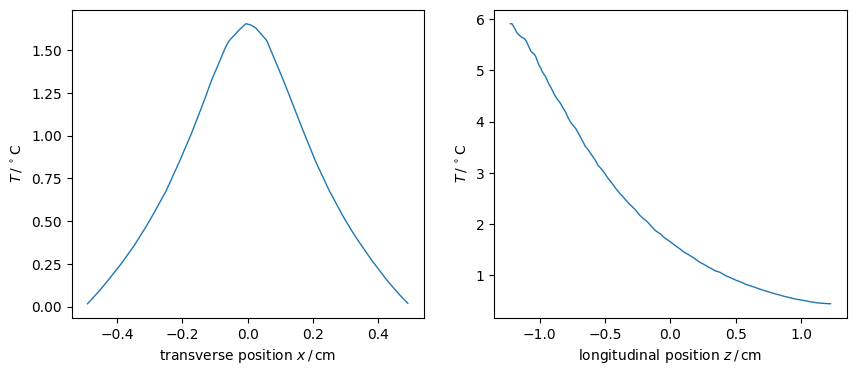

In [8]:
# setup radial and longitudinal temperature plots
n_rows = 1
n_cols = 2
fig = plt.figure(figsize=(10,4))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

m_tol = 2.e-2        # mesh tolerance
n_longpts = 201      # no. of longitudinal points at which to extract data
n_radpts = 201       # no. of radial points at which to extract data
xv = np.linspace(xmin * (1 - m_tol), xmax * (1 - m_tol), n_radpts)
zv = np.linspace(zmin * (1 - m_tol), zmax * (1 - m_tol), n_longpts)
radpts = np.asarray([(x_, 0, 0) for x_ in xv])
axipts = np.asarray([(0, 0, z_) for z_ in zv])

# execute simulation
set_log_level(30)
t0 = tm.time()
solve(F == 0, u, bc)
t1 = tm.time()

ux = np.array([u(pt) for pt in radpts])
uz = np.array([u(pt) for pt in axipts])
T_axis = uz
fig1.plot(xv, ux, lw=1)
fig2.plot(zv, uz, lw=1)

fig1.set_xlabel(r'transverse position $x\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')

# fig.savefig('temp_equil_profiles_compare.png')
fig.show()

print('mesh density: %s, no. of tetrahedral elements: %s, no. of vertices: %s' %(mden, mesh.num_cells(), mesh.num_vertices()))
# print("simulation time: %4.3f minutes" % ((t1 - t0) / 60.0))
print("simulation time: %4.3f seconds" % (t1 - t0))

## Innocenzi benchmarking
Benchmark the temperature calculated via FEniCS with the results put forth by Innocenzi et. al. in "Thermal modeling of continuous-wave end-pumped solid-state lasers", 1990.

In [9]:
# replace zero value in radpts
radpts[n_radpts // 2] = 1e-16

printmd(r'Power input: %s [W]' %P_abs)                # absorbed power [W]
printmd(r'$\alpha:$ %.2f [1/cm]' %(alpha_h))          # absorption coefficient [1/cm]
printmd(r'laser width, $w_p$: %s [cm]' %w_p)          # laser radius [cm]

Power input: 6.7669999999999995 [W]

$\alpha:$ 1.20 [1/cm]

laser width, $w_p$: 0.164 [cm]

In [10]:
# define thermal conductivity to be used for Innocenzi calculation
K_c_inno = K_c_tisaph
printmd(r'$K_c$: %s [W/cm/K]' %K_c_inno)

$K_c$: 0.33 [W/cm/K]

In [11]:
def dT_innocenzi(P_abs, V_eff, K_c, w_p, alpha, r_b, r, z):
    
    # calculate alpha * P_ph
    aP_ph = ((np.pi * w_p**2) / 2)  * (P_abs / V_eff)
    # printmd(r'$\alpha \cdot P_{ph}$: %g [W/cm]' %(aP_ph))
    
    return aP_ph * np.exp(-alpha * z) / (4 * np.pi * K_c) \
         * (np.log(np.square(r_b / r)) + exp1(2 * np.square(r_b / w_p)) - exp1(2 * np.square(r / w_p)))

In [12]:
z_vals = axipts[:, 2] + lh
r_vals = radpts[:, 0]

In [13]:
dT_long_inno = dT_innocenzi(P_abs, V_eff, K_c_inno, w_p, alpha_h, rad, 1e-16, z_vals)
dT_rad_inno  = dT_innocenzi(P_abs, V_eff, K_c_inno, w_p, alpha_h, rad, r_vals, lh)

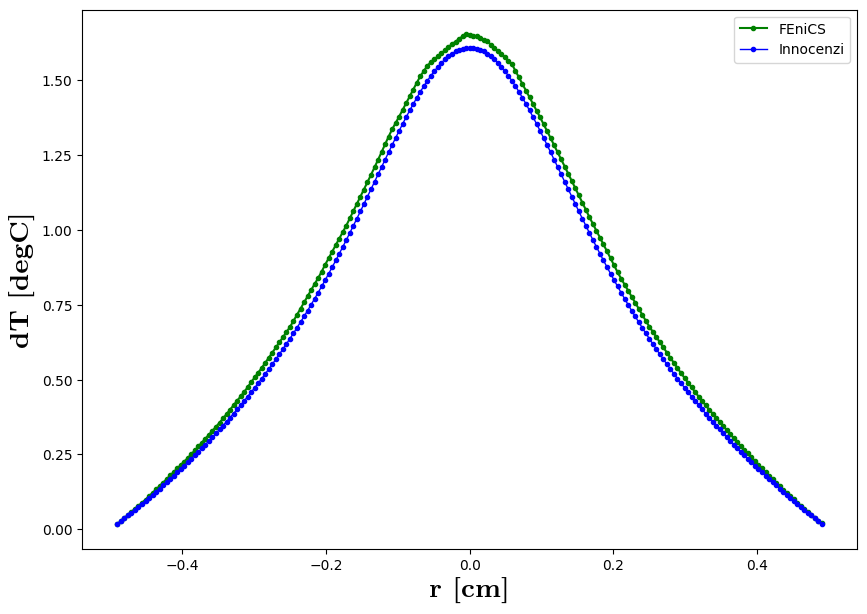

In [14]:
# match analytic/simulation radially
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.plot(r_vals, ux, 'g.-', label = 'FEniCS')
ax.plot(r_vals, dT_rad_inno,'b.-', linewidth = 1, label = 'Innocenzi')
ax.set_ylabel(r'dT [degC]',**hfontMed)
ax.set_xlabel(r'r [cm]',**hfontMed)                         
# ax.set_title(r'Coefficient of Thermal Expansion for $Al_2O_3$',**hfontMed)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1s'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%s'))
#plt.xticks(tvals_10ms)
# plt.grid(True)
ax.legend()
plt.show()

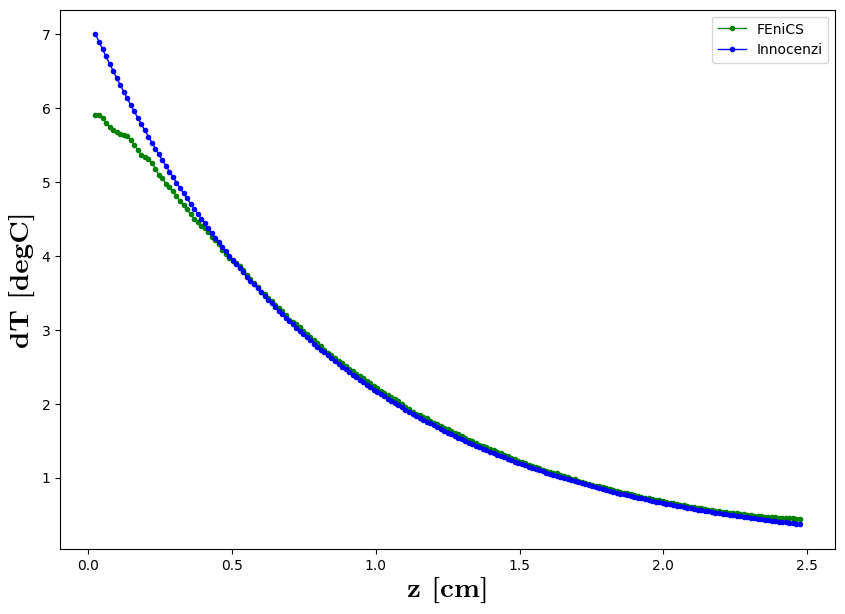

In [15]:
# match analytic/simulation longitudinally
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.plot(z_vals, uz, 'g.-', lw = 1, label = 'FEniCS')
ax.plot(z_vals, dT_long_inno,'b.-', lw = 1, label = 'Innocenzi')
ax.set_ylabel(r'dT [degC]',**hfontMed)
ax.set_xlabel(r'z [cm]',**hfontMed)                         
# ax.set_title(r'Coefficient of Thermal Expansion for $Al_2O_3$',**hfontMed)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1s'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%s'))
#plt.xticks(tvals_10ms)
# plt.grid(True)
ax.legend()
plt.show()

In [16]:
# save data for a given run to plot later
# np.savetxt('data/fenics_alp83_m770.out', uz, delimiter=',')
# np.savetxt('data/inno_alp83_m770.out', dT_long_inno, delimiter=',')

In [17]:
# load data for the various runs
fenics_al2p5_m770 = np.loadtxt('data/fenics_al2p5_m770.out')
inno_al2p5_m770 = np.loadtxt('data/inno_al2p5_m770.out')
fenics_al7p5_m770 = np.loadtxt('data/fenics_al7p5_m770.out')
inno_al7p5_m770 = np.loadtxt('data/inno_al7p5_m770.out')
fenics_alp83_m770 = np.loadtxt('data/fenics_alp83_m770.out')
inno_alp83_m770 = np.loadtxt('data/inno_alp83_m770.out')

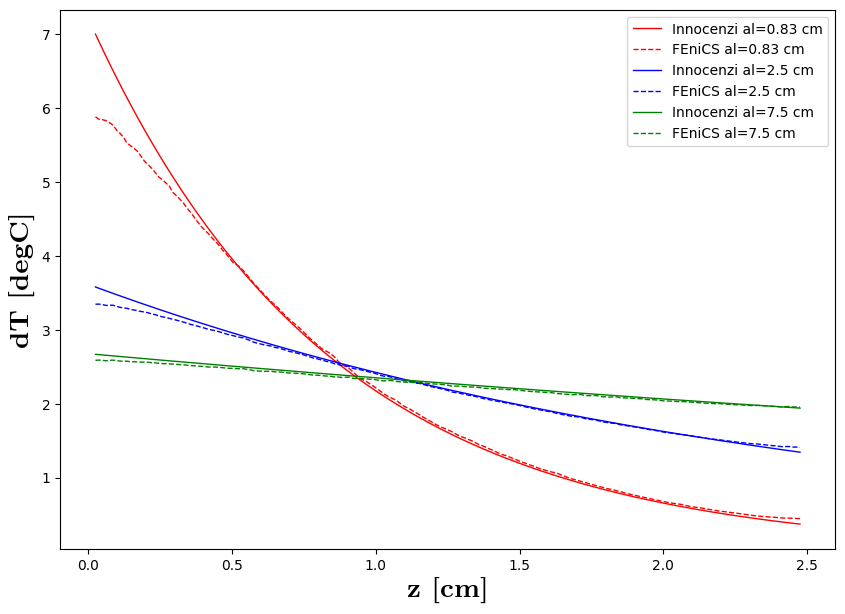

In [18]:
# match analytic/simulation longitudinally for varying cases
fig = plt.figure(figsize=(10,7))
ax = fig.gca()
ax.plot(z_vals, inno_alp83_m770,'r-', lw = 1, label = 'Innocenzi al=0.83 cm')
ax.plot(z_vals, fenics_alp83_m770, 'r--', lw = 1, label = 'FEniCS al=0.83 cm')
ax.plot(z_vals, inno_al2p5_m770,'b-', lw = 1, label = 'Innocenzi al=2.5 cm')
ax.plot(z_vals, fenics_al2p5_m770, 'b--', lw = 1, label = 'FEniCS al=2.5 cm')
ax.plot(z_vals, inno_al7p5_m770,'g-', lw = 1, label = 'Innocenzi al=7.5 cm')
ax.plot(z_vals, fenics_al7p5_m770, 'g--', lw = 1, label = 'FEniCS al=7.5 cm')
ax.set_ylabel(r'dT [degC]',**hfontMed)
ax.set_xlabel(r'z [cm]',**hfontMed)                         
# ax.set_title(r'Coefficient of Thermal Expansion for $Al_2O_3$',**hfontMed)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%1s'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%s'))
#plt.xticks(tvals_10ms)
# plt.grid(True)
ax.legend()
plt.show()

***
### Calculate longitudinal dT slope at entrance

In this section, we will calculate the slope of the longitudinal temperature profile near the crystal entrance.

In [19]:
n_slope = 15

print('first %d values of uz (fenics): %s' %(n_slope, uz[0:n_slope]))
print('first %d values of dT_long_inno (Innocenzi): %s' %(n_slope, dT_long_inno[0:n_slope]))
print('first %d values of zv (fenics): %s' %(n_slope, zv[0:n_slope]))

first 15 values of uz (fenics): [5.90895457 5.90965102 5.86429168 5.80355899 5.7428263  5.70414499
 5.67661313 5.64773469 5.63111572 5.61449675 5.5717386  5.50132304
 5.43090749 5.36808991 5.34156785]
first 15 values of dT_long_inno (Innocenzi): [6.99927095 6.89713421 6.7964879  6.69731027 6.59957989 6.50327563
 6.4083767  6.31486257 6.22271305 6.13190822 6.04242846 5.95425443
 5.86736707 5.78174762 5.69737757]
first 15 values of zv (fenics): [-1.225   -1.21275 -1.2005  -1.18825 -1.176   -1.16375 -1.1515  -1.13925
 -1.127   -1.11475 -1.1025  -1.09025 -1.078   -1.06575 -1.0535 ]


In [20]:
slope_fenics = (uz[n_slope] - uz[0]) / (zv[n_slope] - zv[0])
print('fenics slope (n=%s): %g' %(n_slope, slope_fenics))
# slope_inno = (dT_long_inno[n_slope] - dT_long_inno[0]) / (zv[n_slope] - zv[0])


slope_inno_full = np.diff(dT_long_inno[0:n_slope]) / np.diff(zv[0:n_slope])
slope_inno = slope_inno_full[0]
print('Innocenzi slope (n=%s): %g' %(n_slope, slope_inno))

fenics slope (n=15): -3.23216
Innocenzi slope (n=15): -8.33769


In [21]:
print(zv[0:n_slope])
print(z_vals[0:n_slope])
print(np.diff(zv[0:n_slope]))
print(np.diff(z_vals[0:n_slope]))

[-1.225   -1.21275 -1.2005  -1.18825 -1.176   -1.16375 -1.1515  -1.13925
 -1.127   -1.11475 -1.1025  -1.09025 -1.078   -1.06575 -1.0535 ]
[0.025   0.03725 0.0495  0.06175 0.074   0.08625 0.0985  0.11075 0.123
 0.13525 0.1475  0.15975 0.172   0.18425 0.1965 ]
[0.01225 0.01225 0.01225 0.01225 0.01225 0.01225 0.01225 0.01225 0.01225
 0.01225 0.01225 0.01225 0.01225 0.01225]
[0.01225 0.01225 0.01225 0.01225 0.01225 0.01225 0.01225 0.01225 0.01225
 0.01225 0.01225 0.01225 0.01225 0.01225]


In [22]:
print('FEniCS slope at entrance: %s' %(np.diff(uz[0:n_slope]) / np.diff(zv[0:n_slope])))
print('Innocenzi slope at entrance: %s' %(np.diff(dT_long_inno[0:n_slope]) / np.diff(zv[0:n_slope])))

FEniCS slope at entrance: [ 0.05685248 -3.70280314 -4.95777072 -4.95777072 -3.15765756 -2.24749852
 -2.35742414 -1.35665075 -1.35665075 -3.49046115 -5.74820852 -5.74820852
 -5.1279654  -2.16506612]
Innocenzi slope at entrance: [-8.33769296 -8.21602532 -8.09613311 -7.97799043 -7.86157175 -7.7468519
 -7.6338061  -7.52240992 -7.41263928 -7.30447047 -7.19788011 -7.09284517
 -6.98934296 -6.88735109]


***
## Extract longitudinal temp data for range of radii.
Calculate the longitudinal temperature profiles of a range of radii values ranging from +/- r_max

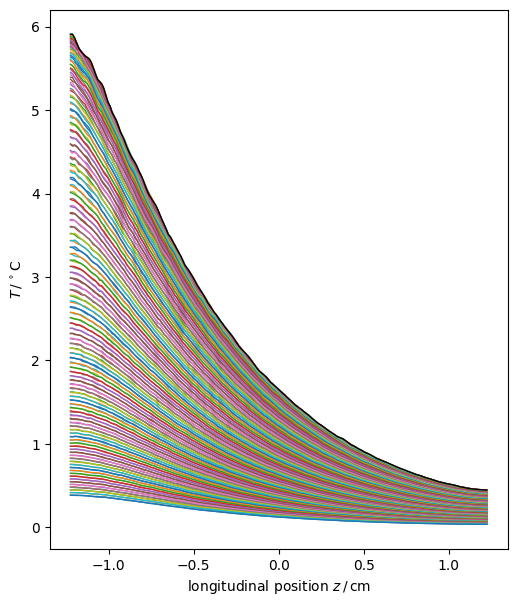

In [23]:
# note:
# throws an error to evaluate at the limits of radpts -
# reduce the value of radpts by some factor, rad_fac
rad_fac = 0.9
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
uz_array = np.zeros((len(radpts), len(zv)))
for j in range(len(radpts)):
    uz_array[j] = [u(pt) for pt in [(radpts[j][0]*rad_fac, 0, z_) for z_ in zv]]
    # print(np.shape(uz_array))
    fig1.plot(zv, uz_array[j], lw=1)
    # fig1.plot(zv, uz_array[j], lw=1, label='{0:5.1f}'.format(radpts[j][0]*.9))
fig1.plot(zv, uz, 'k', lw=1)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
# fig1.legend()
fig.show()

***
## Divide data into n longitudinal slices.
Divide the longitudinal temperature profiles from the figure above into n longitudinal slices.

In [24]:
n_uz = 180                           # no. of longitudinal slices
n_uz_tot = len(radpts) - 1           # total no. of longitudinal profiles in uz_array
print('total no. of longitudinal profiles in uz_array:', n_uz_tot)

# extract only r_x vals from radpts
radpts_array = np.array(radpts)
radpts_x = radpts_array[:,0]
print('shape of radpts_x:', np.shape(radpts_x))

dslice_ind = int(n_uz_tot/n_uz)                 # size of of slice indeces
print('size of slice indices, dslice_ind:', dslice_ind)

for i in range(0,5):
    globals()['x'+str(i)] = i
    
    # print(x1)
print(x0)
print(x1)


total no. of longitudinal profiles in uz_array: 200
shape of radpts_x: (201,)
size of slice indices, dslice_ind: 1
0
1


In [25]:
for j in range(n_uz - 1):
    
    # print(j + 1)
    uz_array0 = np.transpose(uz_array[:,0:dslice_ind])
    zv_array0 = zv[0:dslice_ind]
    radpts_x0 = radpts_array[0:dslice_ind,:]  
    
    globals()['uz_array'+str(j + 1)] = np.transpose(uz_array[:,(dslice_ind*(j+1)):(dslice_ind*(j+2))])
    globals()['zv_array'+str(j + 1)] = zv[(dslice_ind*j):(dslice_ind*(j+1))]
    globals()['radpts_x'+str(j + 1)] = radpts_array[(dslice_ind*j):(dslice_ind*(j+1)),:] 


## Integrate longitudinal temperature profiles

In [26]:
# calculate longitudinal step size, dz
dz = (zv[len(zv) - 1] - zv[0]) / (len(zv) - 1)
print('dz: %.7s cm' %(dz))

for j in range(n_uz):
    globals()['t_int_vals'+str(j)] = []
    # print(j)
    for i in range((len(radpts_x) - 0)):
    # print('j + 1:', j + 1)
    
        globals()['t_int'+str(j)] = np.sum(globals()['uz_array'+str(j)][:,i]) * dz / (leng / n_uz)
        # print(t_int0)
        # print(t_int1)
        globals()['t_int_vals'+str(j)].append(globals()['t_int'+str(j)])
        # t_int0 = np.sum(uz_array0[:,j]) * dz / (leng / n_uz)  # divide by n_uz because leng is now only 1/n_uz*leng_total
        # t_int_vals0.append(t_int0)

dz: 0.01225 cm


In [27]:
# create arrays for T_int(r) and r for region within laser radius
# laser_ran_min = 49 # 49      # min index value of center data range
# laser_ran_max = 152 # 152    # max index value of center data range
laser_ran_min = 83 # 49      # min index value of center data range  # JVT +/- 0.5*w_p
laser_ran_max = 117 # 152    # max index value of center data range  # JVT +/- 0.5*w_p
radpts_x_laser = radpts_x[laser_ran_min:laser_ran_max]

In [28]:
for j in range(n_uz):
    globals()['t_int_vals'+str(j)+str('laser')] = globals()['t_int_vals'+str(j)][laser_ran_min:laser_ran_max]
    # t_int_vals0_laser = t_int_vals0[laser_ran_min:laser_ran_max]

In [29]:
# quad fit function
def quad_int0(x, A, B):
    y = A*x**2 + B
    return y

In [30]:
for j in range(n_uz):
    
    globals()['parameters_q_int'+str(j)], globals()['covariance_q_int'+str(j)] = curve_fit(quad_int0, radpts_x_laser, globals()['t_int_vals'+str(j)+str('laser')])
    
    globals()['fit_Aq_int'+str(j)] = globals()['parameters_q_int'+str(j)][0]
    globals()['fit_Bq_int'+str(j)] = globals()['parameters_q_int'+str(j)][1]
    
    globals()['fit_yq_int'+str(j)] = quad_int0(radpts_x_laser, globals()['fit_Aq_int'+str(j)], globals()['fit_Bq_int'+str(j)])
    
#     parameters_q_int0, covariance_q_int0 = curve_fit(quad_int0, radpts_x_laser, t_int_vals0_laser)

#     fit_Aq_int0 = parameters_q_int0[0]
#     fit_Bq_int0 = parameters_q_int0[1]

#     fit_yq_int0 = quad_int0(radpts_x_laser, fit_Aq_int0, fit_Bq_int0)

$\hspace{13mm}$ $T_{int} = -82.10063 r^2 + 5.18509$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = -82.86242 r^2 + 5.17282$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

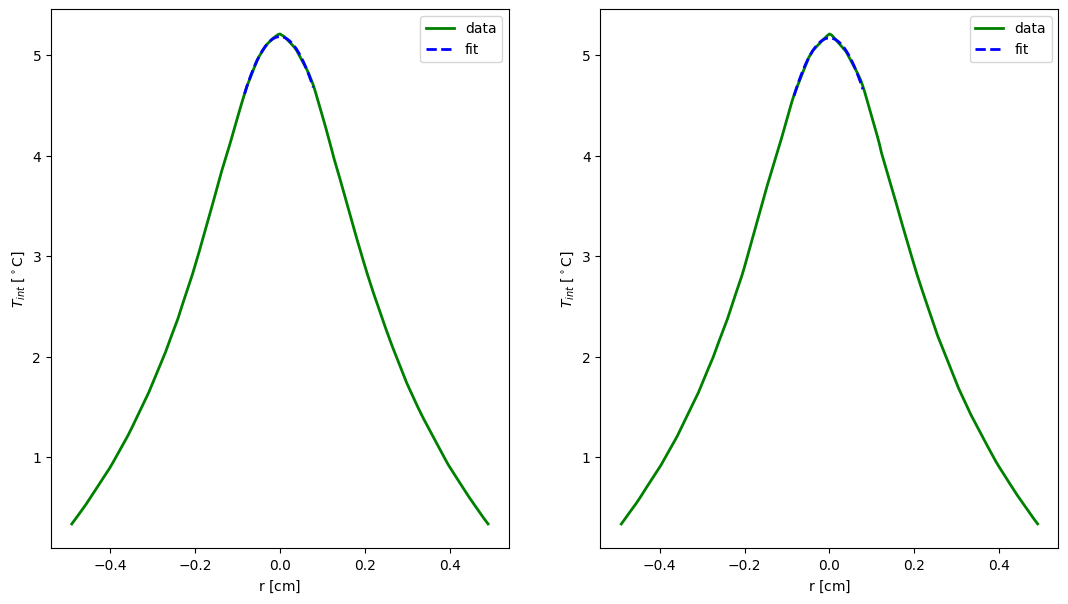

In [31]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, t_int_vals0,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_int0,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig1.set_ylim(0, 10)
fig1.legend()


fig2.plot(radpts_x, t_int_vals1,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_int1,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig2.set_ylim(0, 10)
fig2.legend()

fig.show()

printmd('$\hspace{13mm}$ $T_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_int0, fit_Bq_int0, fit_Aq_int1, fit_Bq_int1))

$\hspace{13mm}$ $T_{int} = -83.19855 r^2 + 5.15404$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = -81.12251 r^2 + 5.11730$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

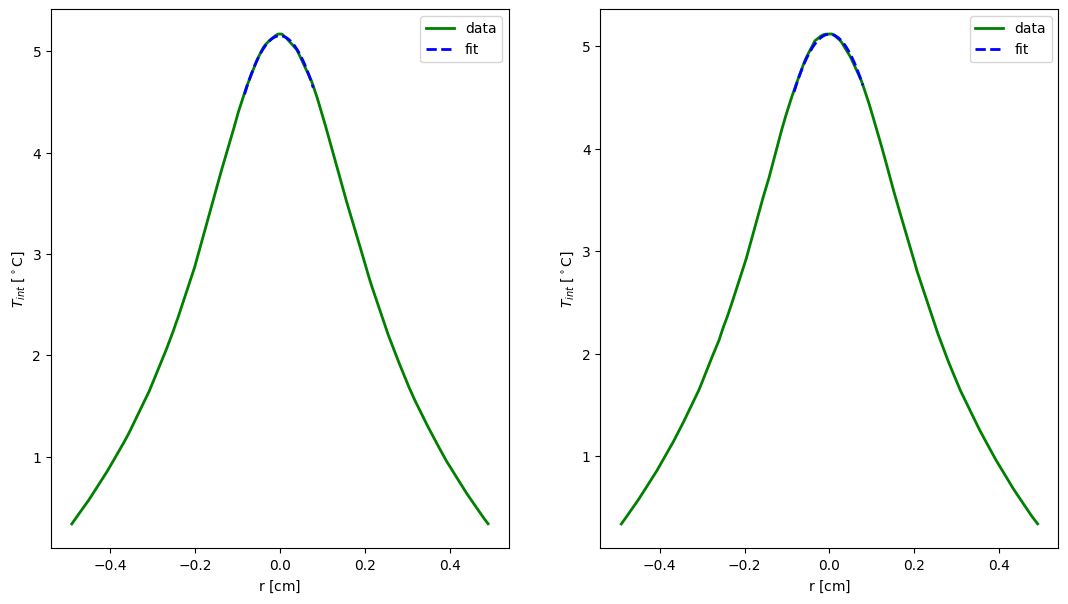

In [32]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, t_int_vals2,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_int2,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig1.set_ylim(0, 6)
fig1.legend()


fig2.plot(radpts_x, t_int_vals3,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_int3,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig2.set_ylim(0, 6)
fig2.legend()

fig.show()

printmd('$\hspace{13mm}$ $T_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_int2, fit_Bq_int2, fit_Aq_int3, fit_Bq_int3))

## Calculate index of refraction for each slice
Here, we will use a formula from Tapping (1986) and a value of dn/dT from Jeong (2018) to calculate the index of refraction, n(r) from T(r) calculated above.

In [33]:
#calculate n_int vals from t_int_vals
chi_T = 1.28e-5
# chi_T taken from:
# Thermal lens effect model of Ti:sapphire for use in
# high-power laser amplifiers - Jeong 2018
# expression for n(T) taken from:
# Tapping 1986
for j in range(n_uz):
    globals()['n_int_vals'+str(j)] = []
    for i in range(len(t_int_vals0)):
        globals()['n_int'+str(j)] = 1.75991 + (chi_T * globals()['t_int_vals'+str(j)][i]) + (3.1e-9 * globals()['t_int_vals'+str(j)][i]**2)
        
        globals()['n_int_vals'+str(j)].append(globals()['n_int'+str(j)])

In [34]:
# create arrays for n_int(r) for region within laser radius and apply quadratic fit
for j in range(n_uz):
    globals()['n_int_vals' + str(j) + '_laser'] = globals()['n_int_vals' + str(j)][laser_ran_min:laser_ran_max]
    globals()['parameters_q_intn' + str(j)], globals()['covariance_q_intn' + str(j)] = curve_fit(quad_int0, radpts_x_laser, globals()['n_int_vals' + str(j) + '_laser'])
    globals()['fit_Aq_intn' + str(j)] = globals()['parameters_q_intn' + str(j)][0]
    globals()['fit_Bq_intn' + str(j)] = globals()['parameters_q_intn' + str(j)][1]
    globals()['fit_yq_intn' + str(j)] = quad_int0(radpts_x_laser, globals()['fit_Aq_intn' + str(j)], globals()['fit_Bq_intn' + str(j)])
    
# extract n0 and n2 values
n2_vals = []
n0_vals = []

for j in range (n_uz):
    n2_vals.append(globals()['fit_Aq_intn' + str(j)])
    n0_vals.append(globals()['fit_Bq_intn' + str(j)])

# fix negative n2 vals and ****divide through by 2 based on Gaussian duct definition n(r) = n0 - 1/2*n2*r^2**** - see rp-photonics.com
n2_vals = np.multiply(n2_vals, -2)
# print(n2_vals)

$\hspace{13mm}$ $n_{int} = -0.00105 r^2 + 1.75998$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $n_{int} = -0.00106 r^2 + 1.75998$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

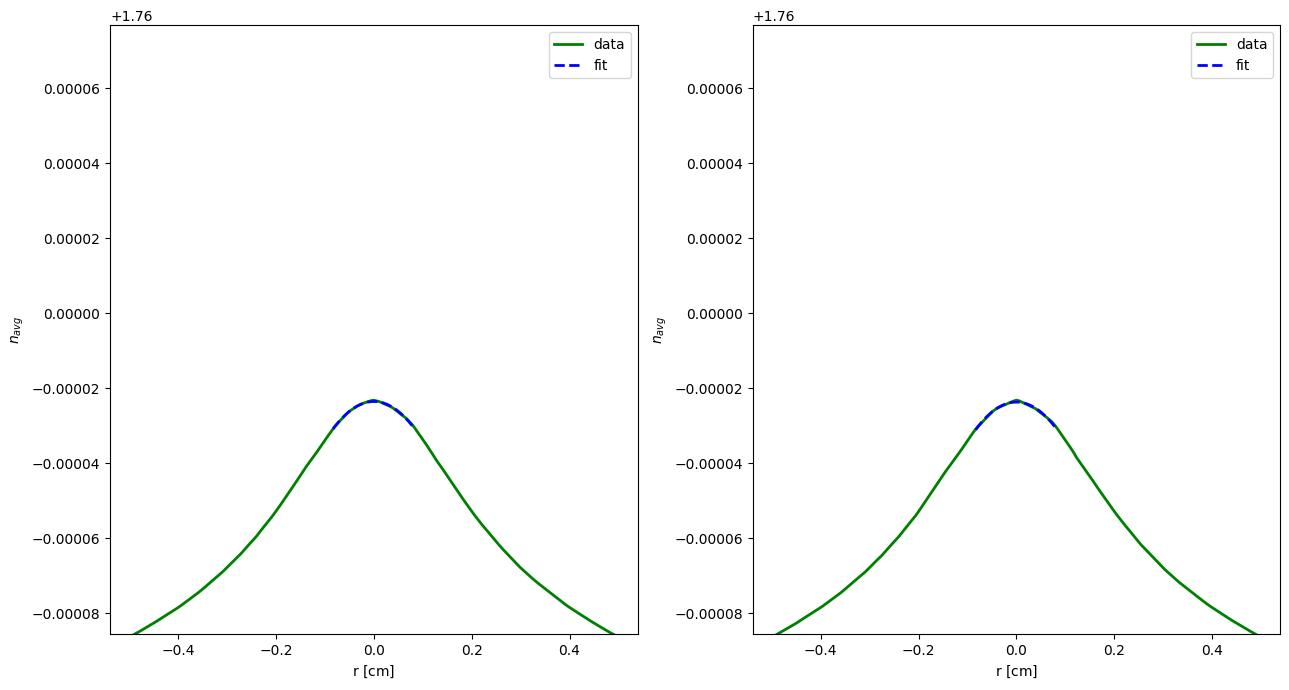

In [35]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, n_int_vals0,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_intn0,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$n_{avg}$')
fig1.set_ylim(np.min(n_int_vals0), np.max(n_int_vals0) + 1e-4)
fig1.legend()


fig2.plot(radpts_x, n_int_vals1,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_intn1,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$n_{avg}$')
fig2.set_ylim(np.min(n_int_vals0), np.max(n_int_vals0) + 1e-4)
# fig2.set_ylim(np.min(n_int_vals1), np.max(n_int_vals1))
fig2.legend()

fig.tight_layout()
fig.show()

printmd('$\hspace{13mm}$ $n_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $n_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_intn0, fit_Bq_intn0, fit_Aq_intn1, fit_Bq_intn1))

In [36]:
l_vals = []
n_int_max_vals = []
for j in range(n_uz):
    n_int_max_val = np.max(globals()['n_int_vals'+str(j)])
    n_int_max_vals.append(n_int_max_val)
    l_val = (leng/n_uz)*j + (0.5 * (leng/n_uz))
    l_vals.append(l_val)

In [37]:
print('n2_entrance: %s [1/m^2]' %(n2_vals[0]*1e4))

n2_entrance: 21.068289875247185 [1/m^2]


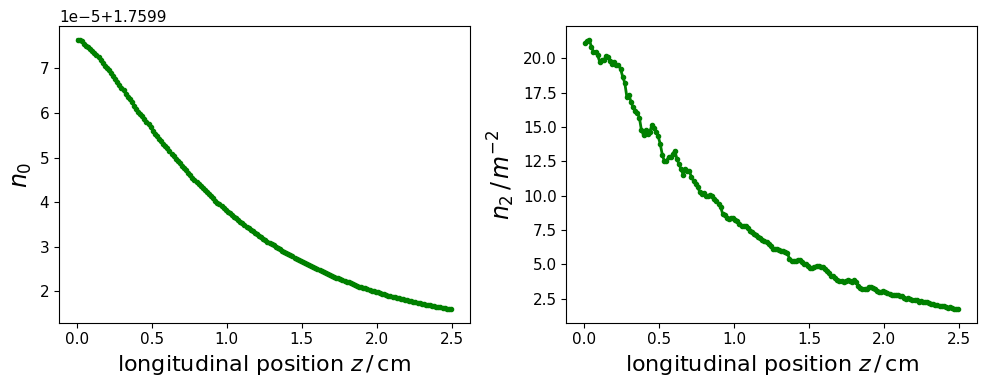

In [38]:
# plot n0 and n2 with increased label font sizes
SMALL_SIZE = 11
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

fig = plt.figure(figsize=(10,4))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(l_vals, n0_vals,'g.-', linewidth = 2)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$', fontsize = 16)
fig1.set_ylabel(r'$n_0$', fontsize = 17)
# fig1.set_ylim(0, 6)
# fig1.legend()

fig2.plot(l_vals, np.multiply(n2_vals, 1e4),'g.-', linewidth = 2)
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$', fontsize = 16)
fig2.set_ylabel(r'$n_2\,/\,{}m^{-2}$', fontsize = 17)
# fig2.set_ylim(0, 6)
# fig2.legend()

# fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
# fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')

fig.tight_layout()
fig.savefig('refractive_index_long_profiles.png')
fig.show()

In [39]:
# calculate avg. of n_2 in m^-2
n_2_vals_m2 = np.multiply(n2_vals, 1e4)
n_2_avg = np.average(n_2_vals_m2)
printmd(r'avg. $n_2$ = %g' %(n_2_avg))

avg. $n_2$ = 8.28273

## ABCD matrix calculation
Here, we calculate an ABCD matrix via n0, n2, and the Gaussian duct formula displayed below.

<img src="figures/gaussian_duct_abcd_mat01.png">

In [40]:
# calculate z (longitudinal length) for each slice of the crystal
leng_slice = leng / n_uz
print('leng_slice: %g [cm]' %(leng_slice))

leng_slice: 0.0138889 [cm]


In [41]:
# extract n0 and n2 values
gamma_vals = np.zeros(n_uz)
for j in range (n_uz):
    gamma_val = np.sqrt(n2_vals[j] / n0_vals[j])
    gamma_vals[j] = gamma_val

In [42]:
# calculate ABCD matrices for each crystal slice and store inside abcd_mats[]
abcd_mats = np.zeros((n_uz, 2, 2))

for j in range (n_uz):
    gamma_z = gamma_vals[j] * leng_slice
    abcd_mats[j, 0, 0] = np.cos(gamma_z)
    abcd_mats[j, 0, 1] = (1 / n0_vals[j] / gamma_vals[j]) * np.sin(gamma_z)
    abcd_mats[j, 1, 0] = (- (n0_vals[j] * gamma_vals[j])) * np.sin(gamma_z)
    abcd_mats[j, 1, 1] = np.cos(gamma_z)
    
print(abcd_mats[15, :, :])

[[ 9.99999893e-01  7.89155024e-03]
 [-2.71340031e-05  9.99999893e-01]]


In [43]:
# test multiplication order of np.matmul()
# a_mat = np.array([[1, 1], [0, 1]])
# b_mat = np.array([[1, 0], [1, 1]])
# ab_mat = np.matmul(a_mat, b_mat)
# print(ab_mat)

In [44]:
# calculate total ABCD matrix by multiplying matrices for individual slices in order M_n-1 * M_n-2 * ... * M_0

abcd_mat_tot_full = np.array( [[1, 0], [0, 1]] )  # initialize total ABCD mat as identity for first multiplication with M_n-1

for j in range (n_uz):
        abcd_mat_tot_full = np.matmul(abcd_mat_tot_full, abcd_mats[n_uz - j - 1, :, :])
        
printmd('$M_{ABCD}$: %s' %(abcd_mat_tot_full))

$M_{ABCD}$: [[ 0.99796102  1.41987267]
 [-0.00206985  0.99909821]]

### ABCD matrix convergence study
Here, a simple convergence study helps to determine the appropriate no. of longitudinal crystal slices required to calculate a solution of our ABCD matrix that approaches numerical convergence.

In [45]:
# construct matrices from less slices by keeping only data every downsample factor from n0 and n2 arrays

ds_fac = 10     # downsample factor, e.g. ds_fac = 3, every third value taken

for j in range(ds_fac - 1):
    globals()['n0_vals_' + str(j + 2)] = n0_vals[::(j + 2)]
    globals()['n2_vals_' + str(j + 2)] = n2_vals[::(j + 2)]
    
    globals()['leng_slice_' + str(j + 2)] = leng / n_uz * (j + 2)

    # globals()['gamma_vals_' + str(j + 2)] = np.sqrt(n2_vals[::(j + 2)] / n0_vals[::(j + 2)])
    globals()['gamma_vals_' + str(j + 2)] = np.sqrt(globals()['n2_vals_' + str(j + 2)] / globals()['n0_vals_' + str(j + 2)])
    
    current_arr_size = np.size(globals()['gamma_vals_' + str(j + 2)])
    print(current_arr_size)
    # globals()['gamma_z']
    
    globals()['abcd_mats_' + str(j + 2)] = np.zeros((current_arr_size, 2, 2))
    
    for k in range(current_arr_size):
        gamma_z = globals()['gamma_vals_' + str(j + 2)][k] * globals()['leng_slice_' + str(j + 2)]
        globals()['abcd_mats_' + str(j + 2)][k, 0, 0] = np.cos(gamma_z)
        globals()['abcd_mats_' + str(j + 2)][k, 0, 1] = (1 / globals()['n0_vals_' + str(j + 2)][k] / globals()['gamma_vals_' + str(j + 2)][k]) * np.sin(gamma_z)
        globals()['abcd_mats_' + str(j + 2)][k, 1, 0] = (- (globals()['n0_vals_' + str(j + 2)][k] * globals()['gamma_vals_' + str(j + 2)][k])) * np.sin(gamma_z)
        globals()['abcd_mats_' + str(j + 2)][k, 1, 1] = np.cos(gamma_z)


print(np.shape(abcd_mats_2))
print(np.shape(abcd_mats_4))
print(np.shape(abcd_mats_6))





# print(np.shape(gamma_vals_2))
# print(np.shape(gamma_vals_4))
# print(np.shape(n0_vals_2))
# print(np.shape(n0_vals_3))
# print(np.shape(n0_vals_4))
# print(np.shape(n0_vals_5))
# print(np.shape(n0_vals_6))
# print(leng_slice)
# print(leng_slice_2)
# print(leng_slice_3)
# print(leng_slice_4)


90
60
45
36
30
26
23
20
18
(90, 2, 2)
(45, 2, 2)
(30, 2, 2)


In [46]:
# calculate total ABCD matrix for each slice-downsampled set of matrices


abcd_mat_tot = np.zeros((ds_fac - 1, 2, 2))

for j in range(ds_fac - 1):
    # print(j)
    # globals()['abcd_mats_' + str(j + 2)][k, 0, 0]
    
    # abcd_mat_tot[j, :, :]
    
    # current_arr_size = np.size(globals()['gamma_vals_' + str(j + 2)])
    current_arr_size = np.size(globals()['gamma_vals_' + str(j + 2)])
    
    abcd_mat_tot[j, :, :] = np.array( [[1, 0], [0, 1]] )
    for k in range(current_arr_size):
        abcd_mat_tot[j, :, :] = np.matmul(abcd_mat_tot[j , :, :], globals()['abcd_mats_' + str(j + 2)][current_arr_size - k - 1, :, :])


print(abcd_mat_tot_full)
print(abcd_mat_tot[0, :, :])
print(abcd_mat_tot[1, :, :])
print(abcd_mat_tot[2, :, :])
print(abcd_mat_tot[3, :, :])
print(abcd_mat_tot[4, :, :])

[[ 0.99796102  1.41987267]
 [-0.00206985  0.99909821]]
[[ 0.99794896  1.4198684 ]
 [-0.00208246  0.99909235]]
[[ 0.99793779  1.41986365]
 [-0.00209491  0.99908583]]
[[ 0.99792751  1.41985874]
 [-0.00210771  0.99907792]]
[[ 0.99791127  1.4198541 ]
 [-0.00212313  0.99907226]]
[[ 0.99789794  1.41984813]
 [-0.00213866  0.99906351]]


In [47]:
sum_sq_diff_arr = []

for j in range (ds_fac - 1):
    abcd_mat_diff = abcd_mat_tot_full - abcd_mat_tot[j, :, :]
    sum_sq_diff = np.square(abcd_mat_diff[0, 0]) + np.square(abcd_mat_diff[0, 1]) + np.square(abcd_mat_diff[1, 0]) + np.square(abcd_mat_diff[1, 1])
    sum_sq_diff_arr.append(sum_sq_diff)
    
print(sum_sq_diff_arr)

[3.572967901301223e-10, 1.4025058123012315e-09, 3.1626262373441655e-09, 6.331779560541476e-09, 1.0520832518541078e-08, 0.0002477641935297352, 0.0009921975605979851, 2.053499992137832e-08, 2.712520923146232e-08]


In [48]:
ds_vals_arr = np.linspace(2, ds_fac, ds_fac - 1)
print(ds_vals_arr)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10.]


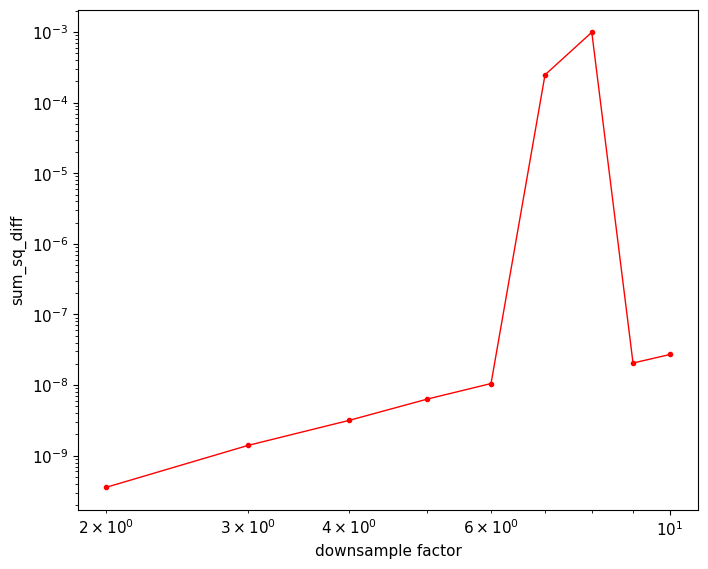

In [49]:
# plot sum of the squares of the difference between full and slice-downsampled total ABCD matrices
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(ds_vals_arr, sum_sq_diff_arr,'r.-', lw = 1)
ax.set_xlabel(r'downsample factor')
ax.set_ylabel(r'sum_sq_diff')
ax.set_yscale('log')
ax.set_xscale('log')
fig.show()

### Check symplecticity of ABCD Matrix

In [50]:
print('det(ABCD): %g' %(linalg.det(abcd_mat_tot_full)))

det(ABCD): 1
